# Работа с временными рядами

In [1]:
!pip install statsmodels==0.12.1

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt


import seaborn as sns
sns.set(palette='Set2', font_scale=1.2)
import pylab as plt
import plotly.graph_objects as go
from IPython.display import display, HTML
from pylab import rcParams
%matplotlib inline

colors = list([
    "#00cc96",
    "#d62728",
    "#9467bd",
    "#8c564b"
])

## 1. Скачаем данные

Загрузим датасет про ежемесячные продажи антидиабетических препаратов в Австралии с 1992 по 2008 год.

In [3]:
title = 'Monthly anti-diabetic drug sales in Australia from 1992 to 2008' 
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv',
                 parse_dates=['date'])
df.index = df['date']
df = df.drop(columns=['date'])
df

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


Сделаем из датасета объект типа `pd.Series` для более удобной работы в дальнейшем.

In [4]:
series = df.copy()
series = series['value']

Изобразим ряд на графике.

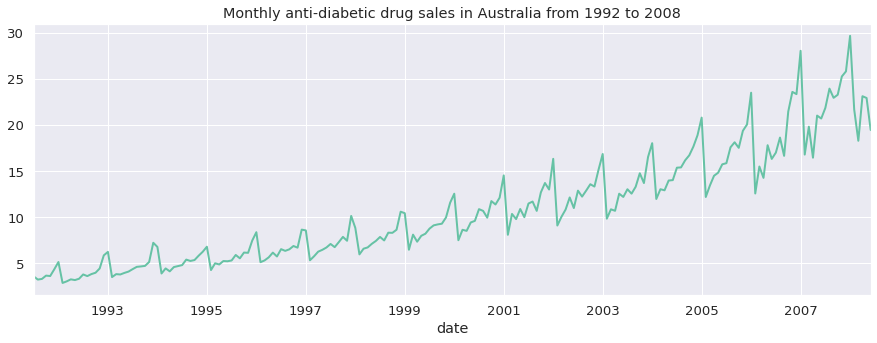

In [5]:
plt.figure(figsize=(15, 5))
plt.title(title)
series.plot(lw=2);

## 2. Анализ ряда
### 2.1 Автокорреляция

Графики автокорреляционной функции (ACF).

<a href="http://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html">`statsmodels.graphics.tsaplots.plot_acf`</a>`(x, ax=None, lags=None, alpha=0.05, use_vlines=True, unbiased=False, fft=False, title='Autocorrelation', zero=True, **kwargs)`

* `x` &mdash; временной ряд;
* `lags` &mdash; набор лагов в виде списка или число (используется `np.arange(lags)`) &mdash; количество лагов, для которых мы считаем корреляцию;
* `ax` &mdash; фигура `matplotlib`;
* `alpha` &mdash; уровень доверия для доверительных интервалов.

На графиках по горизонтальной оси изображены лаги. Синими точками отмечены значения функций, для наглядности рисуется также отрезок, соединяющий их с горизонтальной осью. Закрашенная область соответствует области незначимой корреляции. Все значения, лежащие вне закрашенной области признаются значимо отличными от нуля.

Не забываем также, что в нуле значение всегда равно 1 &mdash; корреляция случайной величины с самой собой.

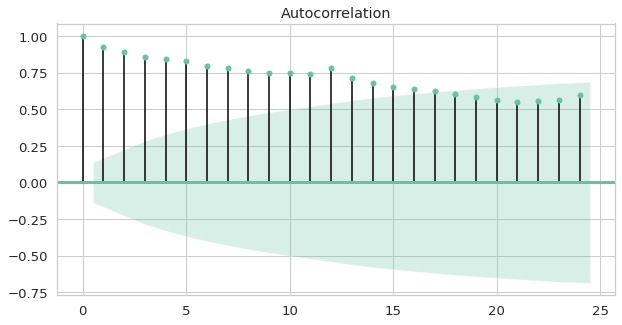

In [6]:
rcParams['figure.figsize'] = 10, 5
with sns.axes_style('whitegrid'):
    statsmodels.graphics.tsaplots.plot_acf(series, lw=3)

### 2.2 Декомпозиция ряда

 <a href="https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html">`statsmodels.tsa.seasonal.seasonal_decompose`</a>`(x, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)`

* `x` &mdash; временной ряд;
* `model` &mdash; `"additive", "multiplicative"`;
* `period` &mdash; период сезонности;
* `two_sided` &mdash; центрированное скользящее среднее или скользящее среднее по предыдущим значениям.

---

Сделаем мультипликативную декомпозицию нашего ряда

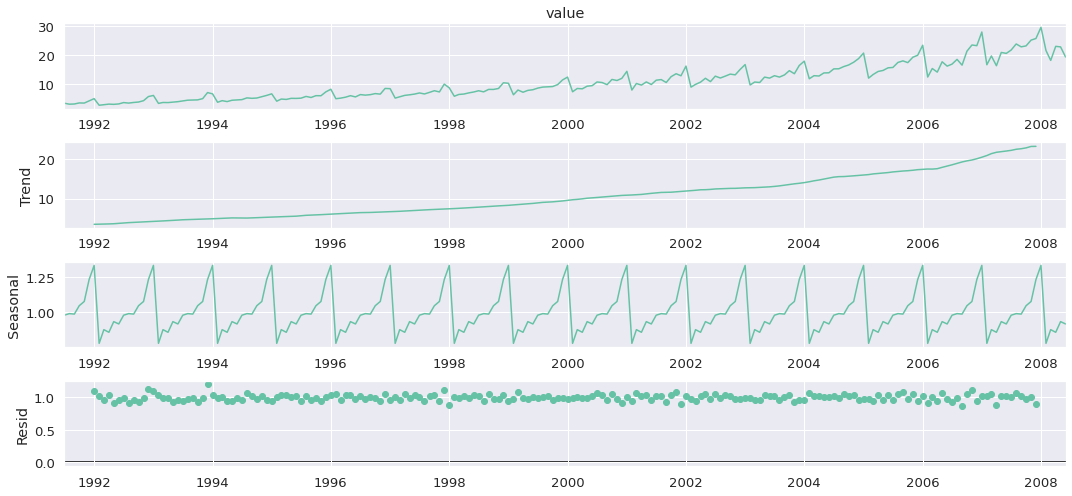

In [7]:
rcParams['figure.figsize'] = 15, 7

simple_result = seasonal_decompose(series, model='multiplicative', period=12)
simple_result.plot();

----

STL-декомпозиция ряда.

<a href="https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.STL.html?highlight=stl#statsmodels.tsa.seasonal.STL">`class statsmodels.tsa.seasonal.STL`</a>`(endog, period=None, seasonal=7, trend=None, low_pass=None, seasonal_deg=0, trend_deg=0, low_pass_deg=0, robust=False, seasonal_jump=1, trend_jump=1, low_pass_jump=1)`

* `endog` &mdash; временной ряд;
* `period` &mdash; период сезонности;
* `robust` &mdash; использовать ли робастные веса в моделях, чтобы не обучаться на выбросы.

---

Сделаем STL-декомпозицию нашего ряда

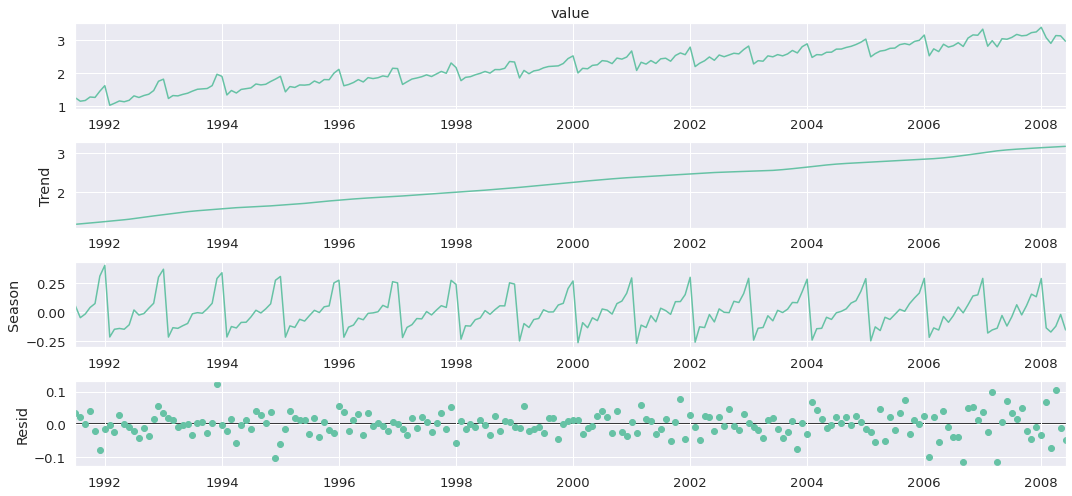

In [8]:
result = STL(np.log(series), period=12).fit()
result.plot();

Посмотрим также на робастную декомпозицию

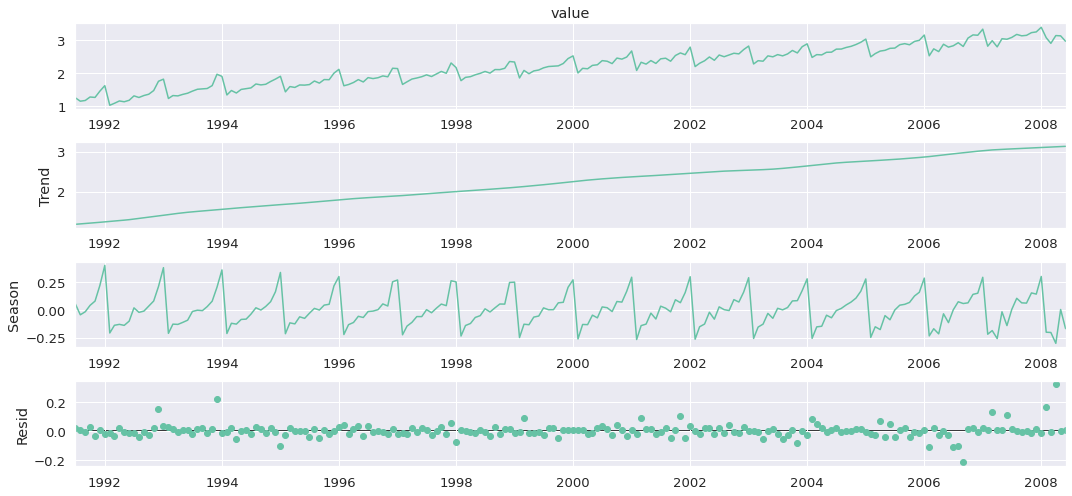

In [9]:
robust_result = STL(np.log(series), period=12, robust=True).fit()
robust_result.plot();

Сравним ошибки 3 моделей:

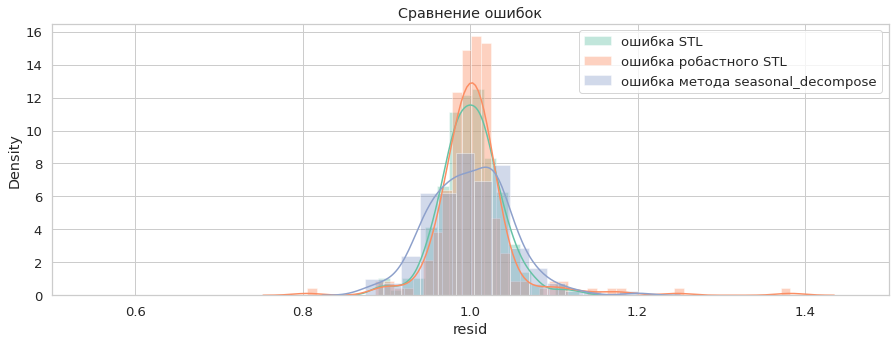

In [10]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(15, 5))
    sns.distplot(np.exp(result.resid), label='ошибка STL')
    sns.distplot(np.exp(robust_result.resid), label='ошибка робастного STL')
    sns.distplot(simple_result.resid, label='ошибка метода seasonal_decompose')
    plt.title("Сравнение ошибок")
    plt.legend()
    plt.xlim(0.5, 1.5)

### 2.3 Тесты на стационарность

**Опреределение стационарности**

Случайный процесс $(X_t, t\in T)$ называется стационарным **в узком** если: 
1. Для любых $t_1, \dots, t_n, \tau$ вектор $(X_{t_1 + \tau}, \dots, X_{t_n + \tau})$ совпадает по распределению с вектором $(X_{t_1}, \dots, X_{t_n})$

Случайный процесс $(X_t, t\in T)$ называется стационарным **в широком смысле** если: 
1. $X_t$ является $L^2$ - процессом, т.е. $\forall t$   $E X_t^2 < \infty$ \
2. $EX_t$ не зависит от $t$
3. $cov(X_{t+\tau}, X_{s + \tau}) = cov(X_t, X_s)$ для любых $s$, $t$, $\tau$


Другими словами, ряд является стационарном в широком смысле, если его математическое ожидание и ковариация не зависят от $t$.

Для гауссовских процессов определения эквивалентны.


**Критерий KPSS**

Проверяет гипотезу $\mathsf{H}_0\colon$ ряд стационарен.

<a href="https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html">`statsmodels.tsa.stattools.kpss`</a>`(x, regression='c', nlags=None, store=False)`

* `x` &mdash; временной ряд;
* `regression` 
    - `"c"` &mdash; данный ряд стационарен.
    - `"ct"`  &mdash; данный ряд стационарен с учетом линейного тренда

$\mathsf{H}_0\colon$ ряд стационарен
    
---

**Критерий Дикки-Фуллера**

Проверяет гипотезу $\mathsf{H}_0\colon$ ряд НЕ стационарен.

<a href="https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html?highlight=adfuller#statsmodels.tsa.stattools.adfuller">`statsmodels.tsa.stattools.adfuller`</a>`(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)`

* `x` &mdash; временной ряд;
* `regression` 
    - `"c"` &mdash; данный ряд стационарен.
    - `"ct"` &mdash; данный ряд стационарен с учетом линейного тренда
    - `"ctt"` &mdash; данный ряд стационарен с учетом линейного и квадратичного тренда
    - `"nc"` &mdash; данный ряд стационарен относительно 0.
* `autolag` &mdash; каким методом проводить стат. тест.

Посмотрим, что скажут про текущий ряд оба критерия. Смотрим только на p-value

In [11]:
kpss(series, regression='c')[1], adfuller(series, regression='c')[1]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1882: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


(0.01, 1.0)

Как видно, их результаты согласованы, ряд не стационарен.

Теперь уберем сезонность и попробуем проверить на стационарность относительно линейного тренда.

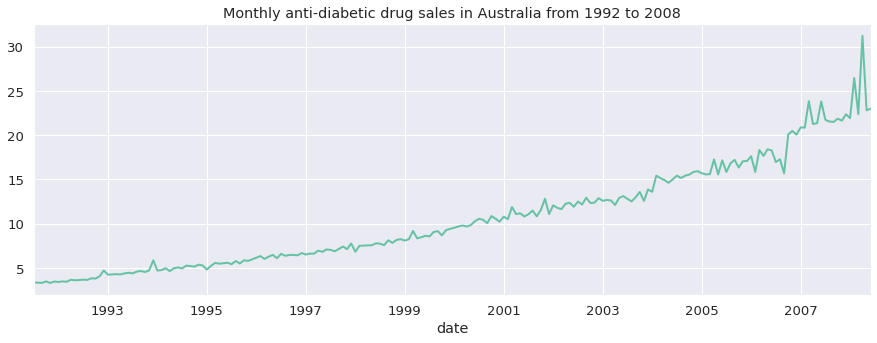

In [12]:
no_seasonal_series = series / np.exp(robust_result.seasonal)

plt.figure(figsize=(15, 5))
plt.title(title)
no_seasonal_series.plot(lw=2);

In [13]:
kpss(no_seasonal_series, regression='ct')[1], adfuller(no_seasonal_series, regression='ct')[1]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1882: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


(0.01, 1.0)

Ряд все еще не стационарен. Посмотрим, а с квадратичным трендом в модели будет ли он стационарен.

In [14]:
adfuller(no_seasonal_series, regression='ctt')[1]

0.9971270750861371

Посмотрим теперь на ошибки при STL-декомпозиции.

In [15]:
kpss(np.exp(robust_result.resid), regression='c')[1], adfuller(np.exp(robust_result.resid), regression='c')[1]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


(0.1, 6.553770517239873e-13)

Здесь, как видно, ряд стационарен и обе модели выдали согласованный результат.

## 3. Предиктивные модели

Зададим частоту временных данных

In [16]:
series.index = pd.DatetimeIndex(series.index.values,
                               freq=series.index.inferred_freq)

Будем предсказывать значения начиначиная с 2007 года.

In [17]:
train_data = series[series.index < pd.to_datetime('2007-01-01')]
predict_data = series[series.index >= pd.to_datetime('2007-01-01')]

Даты начала и окончания прогнозирования

In [18]:
start = predict_data.index.min()
end = predict_data.index.max()

Визуализируем на интерактивном графике обучение и тестовую часть

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data.index, y=list(train_data), 
                         mode='lines', name='обучение'))
fig.add_trace(go.Scatter(x=predict_data.index, y=list(predict_data), 
                         mode='lines', name='будущее'))
fig.update_layout(title=title)
fig.show()

### 3.1 Экспоненциальное сглаживание

<a href="https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html?highlight=simpleexpsmoothing#statsmodels.tsa.holtwinters.SimpleExpSmoothing">`statsmodels.tsa.holtwinters.SimpleExpSmoothing`</a>`(endog, initialization_method=None, initial_level=None)`

- `endog` &mdash; временной ряд.

Прогноз взвешенным средним с экспоненциально убывающими весами.

$\hat{y}_{T+1|t} = \alpha y_T + (1-\alpha) \hat{y}_{T|T-1}$

---

Обучим модель с разными параметрами

In [66]:
# при smoothing_level = 0 предсказываем средним
# при smoothing_level = 1 предсказываем константой

fit1 = SimpleExpSmoothing(train_data, initialization_method="heuristic")\
    .fit(smoothing_level=0.2, optimized=False)  

fit2 = SimpleExpSmoothing(train_data, initialization_method="heuristic")\
    .fit(smoothing_level=0.6, optimized=False)

fit3 = SimpleExpSmoothing(train_data, initialization_method="estimated").fit()

Сделаем прогнозы

In [67]:
fcast1 = fit1.predict(start=start, end=end)
fcast2 = fit2.predict(start=start, end=end)
fcast3 = fit3.predict(start=start, end=end)

Cоздание таблички с результатами и параметрами модели

In [68]:
last_alpha = round(fit3.model.params['smoothing_level'], 2)
labels = ['alpha=0.2', 'alpha=0.6', f'alpha={last_alpha}']

params = ['smoothing_level', 'initial_level']
results=pd.DataFrame(index=[r"$\alpha$",r"$l_0$","SSE", "test MSE"],
                     columns=labels)

# SSE - sum of squared errors
# l_0 - начальное значение
for index in[1, 2, 3]:
    results[labels[index - 1]] = [globals()[f"fit{index}"].params[p] for p in params] +\
                                 [globals()[f"fit{index}"].sse] +\
                                 [mean_squared_error(predict_data, globals()[f"fcast{index}"])]
display(results)

,alpha=0.2,alpha=0.6,alpha=0.44
$\alpha$,0.200000,0.600000,0.442150
$l_0$,3.596235,3.596235,3.442373
SSE,591.638282,581.097293,573.194540
test MSE,17.464731,12.190649,11.935061


Визуализируем результаты

In [69]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data.index, y=list(train_data), 
                         mode='lines', name='обучение'))
fig.add_trace(go.Scatter(x=predict_data.index, y=list(predict_data), 
                         mode='lines', name='будущее'))

for index in [1, 2, 3]:
    on_train = globals()[f"fit{index}"].fittedvalues
    on_test = globals()[f"fcast{index}"]
    
    for dataset_str in ['on_train', 'on_test']:
        dataset = globals()[dataset_str]
        label = dataset_str + ": " + labels[index - 1]
        fig.add_trace(go.Scatter(
            x=dataset.index, y=list(dataset), line=dict(color=colors[index-1]),
            mode='lines', name=label
        ))

fig.update_layout(title=title)
fig.show()

### 3.2 Модель Хольта

<a href="https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.Holt.html?highlight=holt#statsmodels.tsa.holtwinters.Holt">`statsmodels.tsa.holtwinters.Holt`</a>`(endog, exponential=False, damped_trend=False, initialization_method=None, initial_level=None, initial_trend=None)`

- `endog` &mdash; временной ряд.
- `exponential` &mdash; тип тренда.
- `damped_trend` &mdash; тренд затухает со временем или нет


  Уравнение прогноза: \
  $\hat{y}_{t+h|t} = \ell_{t} + hb_{t}$, \
 $ \ell_{t} = \alpha y_{t} + (1 - \alpha)(\ell_{t-1} + b_{t-1}) $ \
 $ b_{t} = \beta^*(\ell_{t} - \ell_{t-1}) + (1 -\beta^*)b_{t-1} $

---

Обучим модель с разными параметрами

In [100]:
fit1 = Holt(train_data, initialization_method="estimated").fit()
fit2 = Holt(train_data, exponential=True, initialization_method="estimated").fit()
fit3 = Holt(train_data, damped_trend=True, initialization_method="estimated").fit()
fit4 = Holt(train_data, exponential=True, damped_trend=True, initialization_method="estimated").fit()

Сделаем прогнозы

In [101]:
fcast1 = fit1.predict(start=start, end=end)
fcast2 = fit2.predict(start=start, end=end)
fcast3 = fit3.predict(start=start, end=end)
fcast4 = fit4.predict(start=start, end=end)

Cоздание таблички с результатами и параметрами модели

In [102]:
labels = ["Holt's linear trend", 'Exponential trend', 
          f'Additive damped trend', "Exponential damped trend"]

params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 
          'initial_level', 'initial_trend']
results=pd.DataFrame(index=[r"$\alpha$", r"$\beta$", r"$\phi$",
                            r"$l_0$", "$b_0$", "SSE", "test MSE"] ,
                     columns=labels)

for index in [1, 2, 3, 4]:
    results[labels[index - 1]] = [globals()[f"fit{index}"].params[p] for p in params] +\
                                 [globals()[f"fit{index}"].sse] +\
                                 [mean_squared_error(predict_data, globals()[f"fcast{index}"])]
display(results)

,Holt's linear trend,Exponential trend,Additive damped trend,Exponential damped trend
$\alpha$,0.052543,1.512482e-08,0.064591,0.039138
$\beta$,0.052543,1.308365e-08,0.064591,0.039138
$\phi$,NaN,NaN,0.995000,0.995000
$l_0$,3.279974,3.683364e+00,3.234656,3.364911
$b_0$,0.045768,1.009047e+00,0.052510,1.016064
SSE,529.469741,4.885176e+02,538.243937,519.947250
test MSE,15.061192,1.249993e+01,14.768442,15.227242


Визуализируем результаты

In [103]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data.index, y=list(train_data), 
                         mode='lines', name='обучение'))
fig.add_trace(go.Scatter(x=predict_data.index, y=list(predict_data), 
                         mode='lines', name='будущее'))


for index in [1, 2, 3, 4]:
    on_train = globals()[f"fit{index}"].fittedvalues
    on_test = globals()[f"fcast{index}"]
    
    for dataset_str in ['on_train', 'on_test']:
        dataset = globals()[dataset_str]
        label = dataset_str +": "+ labels[index - 1]
        fig.add_trace(go.Scatter(
            x=dataset.index, y=list(dataset), line=dict(color=colors[index-1]),
            mode='lines', name=label
        ))
        
fig.update_layout(title=title)
fig.show()

### 3.3 Модель Хольта-Уинтерса

<a href="https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html?highlight=exponentialsmoothing#statsmodels.tsa.holtwinters.ExponentialSmoothing">`statsmodels.tsa.holtwinters.ExponentialSmoothing`</a>`(endog, trend=None, damped_trend=False, seasonal=None, *, seasonal_periods=None, initialization_method=None, initial_level=None, initial_trend=None, initial_seasonal=None, use_boxcox=None, bounds=None, dates=None, freq=None, missing='none')[`

- `endog` &mdash; временной ряд.
- `trend` &mdash; `"add", “mul", "additive", "multiplicative"`
- `seasonal` &mdash; `"add", “mul", "additive", "multiplicative"`
- `damped_trend` &mdash; тренд затухает со временем или нет

Уравнение прогноза: \

$\hat{y}_{t+h|t} = \ell_{t} + hb_{t} + s_{t+h-m(k+1)}$ \
$\ell_{t} = \alpha(y_{t} - s_{t-m}) + (1 - \alpha)(\ell_{t-1} + b_{t-1})$ \
$b_{t} = \beta^*(\ell_{t} - \ell_{t-1}) + (1 - \beta^*)b_{t-1}$ \
$s_{t} = \gamma (y_{t}-\ell_{t-1}-b_{t-1}) + (1-\gamma)s_{t-m}$

---

Обучим модель с разными параметрами

In [74]:
fit1 = ExponentialSmoothing(
    train_data, seasonal_periods=12, trend='add', seasonal='add',
    use_boxcox=True, initialization_method="estimated"
).fit()

fit2 = ExponentialSmoothing(
    train_data, seasonal_periods=12, trend='add', seasonal='mul', 
    use_boxcox=True, initialization_method="estimated"
).fit()

fit3 = ExponentialSmoothing(
    train_data, seasonal_periods=12, trend='add', seasonal='add', 
    damped_trend=True, use_boxcox=True, initialization_method="estimated"
).fit()

fit4 = ExponentialSmoothing(
    train_data, seasonal_periods=12, trend='add', seasonal='mul', 
    damped_trend=True, use_boxcox=True, initialization_method="estimated"
).fit()

Сделаем прогнозы

In [75]:
fcast1 = fit1.predict(start=start, end=end)
fcast2 = fit2.predict(start=start, end=end)
fcast3 = fit3.predict(start=start, end=end)
fcast4 = fit4.predict(start=start, end=end)

Cоздание таблички с результатами и параметрами модели

In [76]:
labels = ["Additive", 'Multiplicative', f'Additive Dam', "Multiplicative Dam"]
params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 'smoothing_seasonal', 
          'initial_level', 'initial_trend']
results=pd.DataFrame(index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$",
                            r"$l_0$", "$b_0$", "SSE", "test MSE"] ,
                     columns=labels)

for index in[1, 2, 3, 4]:
    results[labels[index - 1]] = [globals()[f"fit{index}"].params[p] for p in params] +\
                                 [globals()[f"fit{index}"].sse] +\
                                 [mean_squared_error(predict_data, globals()[f"fcast{index}"])]
display(results)

,Additive,Multiplicative,Additive Dam,Multiplicative Dam
$\alpha$,0.139453,0.107757,1.627863e-01,0.122456
$\beta$,0.000000,0.000000,2.314433e-02,0.019821
$\phi$,NaN,NaN,9.950000e-01,0.995000
$\gamma$,0.000000,0.599897,1.348332e-13,0.588284
$l_0$,1.265632,1.282281,1.243073e+00,1.270995
$b_0$,0.011940,0.011205,1.585230e-02,0.014101
SSE,67.391865,83.890366,7.102117e+01,87.131407
test MSE,4.965575,7.039425,6.816504e+00,9.064746


Визуализируем результаты

In [77]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data.index, y=list(train_data), 
                         mode='lines', name='обучение'))
fig.add_trace(go.Scatter(x=predict_data.index, y=list(predict_data), 
                         mode='lines', name='будущее'))

for index in [1, 2, 3, 4]:
    on_train = globals()[f"fit{index}"].fittedvalues
    on_test = globals()[f"fcast{index}"]
    for dataset_str in ['on_train', 'on_test']:
        dataset = globals()[dataset_str]
        label = dataset_str +": "+ labels[index - 1]
        fig.add_trace(go.Scatter(
            x=dataset.index, y=list(dataset), line=dict(color=colors[index-1]),
            mode='lines', name=label
        ))
        
fig.update_layout(title=title)
fig.show()

Как видно, эта модель отработала лучше всего.

Она также может строить предсказательный интервал, эмулируюя различные возможные значения.

In [104]:
fit1 = ExponentialSmoothing(train_data, seasonal_periods=12, trend='add', seasonal='add',
                            use_boxcox=True, initialization_method="estimated").fit()
fcast1 = fit1.predict(start=start, end=end)
simulations = fit1.simulate(len(predict_data), anchor=start, repetitions=1000, 
                            error='add', random_errors='bootstrap')

Визуализируем результат

In [105]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data.index, y=list(train_data), mode='lines', name='train'))
fig.add_trace(go.Scatter(x=predict_data.index, y=list(predict_data), mode='lines', name='to predict'))

labels = ["Additive", 'Multiplicative', f'Additive Dam', "Multiplica Dam"]
for index in[1]:
    on_train = globals()[f"fit{index}"].fittedvalues
    on_test = globals()[f"fcast{index}"]
    
    for dataset_str in ['on_train', 'on_test']:
        dataset = globals()[dataset_str]
        label = dataset_str +": "+ labels[index - 1]
        fig.add_trace(go.Scatter(x=dataset.index, y=list(dataset), line=dict(color=colors[index-1]),
                                 mode='lines', name=label))
        
    for i in range(100):
        curr_series = simulations[i]
        fig.add_trace(go.Scatter(x=curr_series.index, y=list(curr_series), line=dict(color='grey', width=0.1),
                                 mode='lines', showlegend=False))
fig.update_layout(title=title)
fig.show()

Отлично, теперь у вас есть минимальные познания для построения предсказательных моделей во временных рядах!